### puppy量化第2课-作业

In [284]:
import pandas as pd
import numpy as np
import os

import talib as ta
import time
import datetime
import warnings

warnings.filterwarnings('ignore')

from joblib import Parallel, delayed

In [285]:
data_path = '十种大宗商品指数文件/'

In [286]:
file_names = list(os.listdir(data_path))
file_names

['pta指数.xlsx',
 '塑料指数.xlsx',
 '橡胶指数.xlsx',
 '沪铜指数.xlsx',
 '沪锌指数.xlsx',
 '白糖指数.xlsx',
 '螺纹钢指数.xlsx',
 '豆油指数.xlsx',
 '豆粕指数.xlsx',
 '铁矿石指数.xlsx']

In [287]:
df_data = pd.read_excel(data_path + file_names[0])
df_data.dropna(inplace=True)
df_data

,代码,名称,日期,开盘价(元),最高价(元),最低价(元),收盘价(元),成交额(百万),成交量(股),结算价
0,TAFI.WI,PTA指数,2006-12-18,8833.27,8833.27,8833.27,8833.27,2199.58,49396.0,8881.87
1,TAFI.WI,PTA指数,2006-12-19,8867.51,8867.51,8867.51,8867.51,2220.38,49906.0,8866.23
2,TAFI.WI,PTA指数,2006-12-20,8919.04,8919.04,8919.04,8919.04,1170.49,26180.0,8909.53
3,TAFI.WI,PTA指数,2006-12-21,8870.84,8870.84,8870.84,8870.84,880.08,19754.0,8873.15
4,TAFI.WI,PTA指数,2006-12-22,8880.97,8880.97,8880.97,8880.97,457.28,10300.0,8842.22
...,...,...,...,...,...,...,...,...,...,...
3934,TAFI.WI,PTA指数,2023-02-24,5584.70,5639.20,5567.92,5631.04,56431.25,2013593.0,0.00
3935,TAFI.WI,PTA指数,2023-02-27,5625.04,5652.81,5527.11,5536.46,66135.22,2361800.0,0.00
3936,TAFI.WI,PTA指数,2023-02-28,5540.54,5617.59,5511.59,5608.79,66516.00,2386902.0,0.00
3937,TAFI.WI,PTA指数,2023-03-01,5619.42,5732.36,5605.29,5732.26,75172.34,2646330.0,0.00


In [288]:
df_data = df_data.rename(columns={'日期':'datetime', '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close', '成交额(百万)': 'amount', '成交量(股)':'volume'})
del  df_data['结算价']
df_data.set_index(['datetime'],drop=True,inplace=True)
df_data

,代码,名称,open,high,low,close,amount,volume
datetime,,,,,,,,
2006-12-18,TAFI.WI,PTA指数,8833.27,8833.27,8833.27,8833.27,2199.58,49396.0
2006-12-19,TAFI.WI,PTA指数,8867.51,8867.51,8867.51,8867.51,2220.38,49906.0
2006-12-20,TAFI.WI,PTA指数,8919.04,8919.04,8919.04,8919.04,1170.49,26180.0
2006-12-21,TAFI.WI,PTA指数,8870.84,8870.84,8870.84,8870.84,880.08,19754.0
2006-12-22,TAFI.WI,PTA指数,8880.97,8880.97,8880.97,8880.97,457.28,10300.0
...,...,...,...,...,...,...,...,...
2023-02-24,TAFI.WI,PTA指数,5584.70,5639.20,5567.92,5631.04,56431.25,2013593.0
2023-02-27,TAFI.WI,PTA指数,5625.04,5652.81,5527.11,5536.46,66135.22,2361800.0
2023-02-28,TAFI.WI,PTA指数,5540.54,5617.59,5511.59,5608.79,66516.00,2386902.0


#### 作业3：用slope来表示5个周期的20日均线向上——talib查询slope函数，dataframe里面，生成slope-series

In [292]:
df = df_data.copy()
df['ma_20'] = df['close'].rolling(20).mean()
df['slope'] = ta.LINEARREG_SLOPE(df['ma_20'],5)

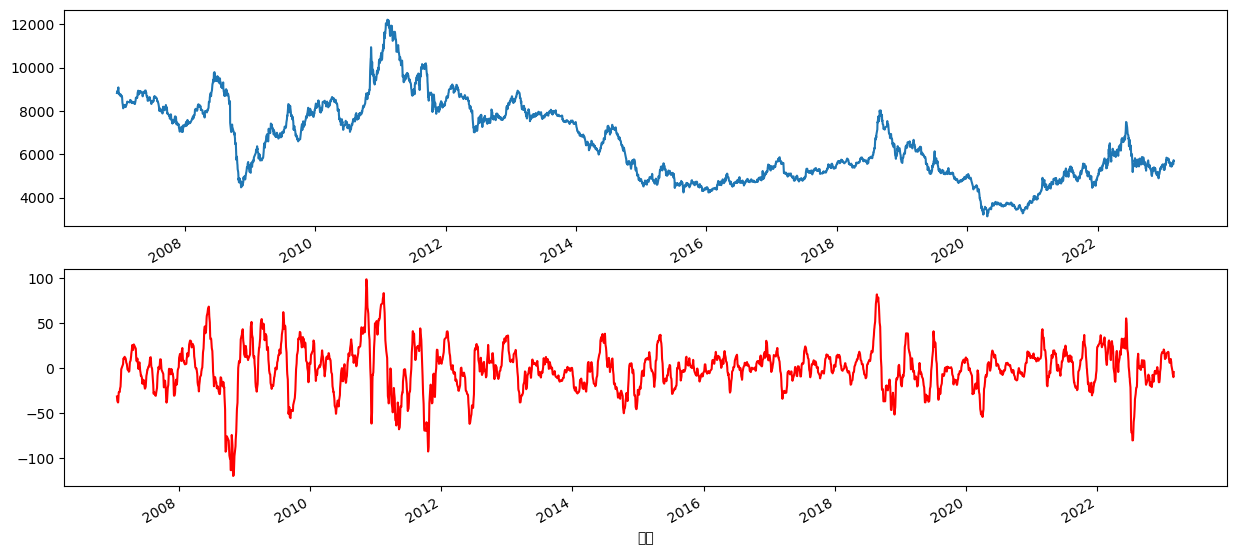

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,7))
plt.subplot(211)
df['close'].plot();
plt.subplot(212)
df['slope'].plot(color='r');
plt.xlabel('日期');

#### 分割线--------------------------------------------------------------------------------------------------

In [241]:
def show_performance(transactions, strategy):
    # 年化收益率
    N = 250
    rety = strategy['nav'][strategy.shape[0] - 1]**(N/strategy.shape[0]) - 1
    # 夏普比
    Sharp = (strategy['ret'] * strategy['position']).mean() / (strategy['ret'] * strategy['position']).std() * np.sqrt(N)
    # 胜率
    VictoryRatio = ((transactions['卖出价格'] - transactions['买入价格']) > 0).mean()
    # 最大回撤率
    DD = 1 - strategy.nav / strategy.nav.cummax()
    MDD = max(DD)

    # 单次最大亏损
    # maxloss = min(transactions['卖出价格'] / transactions['买入价格'] - 1)
    
    # 月均交易次数
    trade_count = strategy.flag.abs().sum() / strategy.shape[0] * 20

    result = {'Sharp': Sharp,
              'Annual_Return': rety,
              'Winning_Rate': VictoryRatio,
              'MDD': MDD,
              'Trading_Num': round(strategy.flag.abs().sum() / strategy.shape[0], 1)
              }
    result = pd.DataFrame.from_dict(result, orient='index').T
    print(result)

    return result

In [252]:
def cal_one_loop(df_data, Strategy_Class, para):
    trans, data = Strategy_Class.strategy(df_data, para)
    result = show_performance(trans, data)
    result['para'] = str(para)
    return result        

### 作业2和作业4
#### 1.ER效率指标策略
#### 2.N倍ATR作为高点回落出局条件

In [289]:
# 该策略使用了N倍ATR作为高点回落出局条件
class Strategy_ER():

    name = 'ER效率指标策略'
    
    ATR_period = 10

    def  __init__(self) -> None:
        pass

    def para_list(self, n_list = range(5,55,5), t_list=[i/20 for i in list(np.arange(2,19,2))]):
        para_list = []
        for n in n_list:
            for t in t_list:
                para = {'n':n, 'threshold':t}
                #para = [n,t]
                para_list.append(para)
        return para_list
    
    def cal_ER(self,ser):
        numerator = ser.iloc[-1] - ser.iloc[0]
        denominator = abs(ser-ser.shift(1)).sum()
        return numerator/denominator

    def strategy(self, df_data, *args):
        n = args[0]['n']
        threshold = args[0]['threshold']
        stop_Atr = args[0]['stop_Atr']
        
        df= df_data.copy()

        df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod = self.ATR_period)
        df['ATR'].fillna(0, inplace=True)
        
        df['ER'+str(n)] = df['close'].rolling(n).apply(self.cal_ER)

        df['position'] = 0
        df['flag'] = 0
        df = df.replace([np.inf, -np.inf, np.nan], 0.0)

        Buy = []
        Sell = []
        price_in_long = 0.0
        price_out_long = 0.0 
        price_in_short = 0.0
        price_out_short = 0.0
        
        for i in range(max(max(10, n), self.ATR_period), df.shape[0]):
            
            if df['position'][i-1] == 0 :
                if (df['ER'+str(n)][i-1]< threshold) and (df['ER'+str(n)][i] >= threshold):
                    df['flag'][i] = 1
                    df['position'][i] = 1
                    date_in = df.index[i]
                    price_in_long = df['close'][i]
                    entry_index = i
                    Buy.append([date_in, price_in_long, '多头买入开仓'])
                elif (df['ER'+str(n)][i-1] > -threshold) and (df['ER'+str(n)][i] <= -threshold):
                    df['flag'][i] = -1
                    df['position'][i] = -1
                    date_in = df.index[i]
                    price_in_short = df['close'][i]
                    entry_index = i
                    Sell.append([date_in, price_in_short, '空头卖出开仓'])
                else:
                    df['position'][i] = df['position'][i-1]
            elif df['position'][i-1] == 1:
                if (df['ER'+str(n)][i-1] > -threshold) and (df['ER'+str(n)][i] <= -threshold):
                    df['flag'][i] = -1
                    df['position'][i] = -1
                    date_in = df.index[i]
                    date_out = df.index[i]
                    price_out_long = df['close'][i]
                    price_in_short = df['close'][i]
                    entry_index = i
                    Sell.append([date_out, price_out_long, '多头卖出平仓'])
                    Sell.append([date_in, price_in_short, '空头卖出开仓'])
                elif (max(df['high'][i-9:i])-df['close'][i]) > (df['ATR'].iloc[i-1] * stop_Atr):
                    df['flag'][i] = -1
                    df['position'] = 0
                    date_out = df.index[i]
                    price_out_long = df['close'][i]
                    Sell.append([date_out, price_out_long, '多头卖出平仓'])
                else:
                    df['position'][i] = df['position'][i-1]
            elif df['position'][i-1] == -1:
                if (df['ER'+str(n)][i-1]< threshold) and (df['ER'+str(n)][i] >= threshold):
                    df['flag'][i] = 1
                    df['position'][i] = 1
                    date_in = df.index[i]
                    date_out = df.index[i]
                    price_in_long = df['close'][i]
                    price_out_short = df['close'][i]
                    entry_index = i
                    Buy.append([date_out, price_out_short, '空头买入平仓'])
                    Buy.append([date_in, price_in_long, '多头买入开仓'])
                elif (min(df['low'][i-9:i])-df['close'][i]) < - (df['ATR'].iloc[i-1] * stop_Atr):
                    df['flag'][i] = 1
                    df['position'][i] = 0
                    date_out = df.index[i]
                    price_out_short = df['close'][i]
                    Buy.append([date_out, price_out_short, '空头买入平仓'])
                else:
                    df['position'][i] = df['position'][i-1]
        
        p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
        p2 = pd.DataFrame(Sell,columns=['卖出日期', '卖出价格', '备注'])
        transactions = pd.concat([p1,p2], axis=1)

        df_ = df.iloc[max(max(1, n), self.ATR_period)-1:, :]
        df_['position'] = df_['position'].shift(1).fillna(0)
        df_['ret'] = df_['close'].pct_change(1).fillna(0)
        df_['nav'] = (1 + df_['ret'] * df_['position']).cumprod()
        df_['benchmark'] = df_['close'] / df_['close'][0]

        return transactions, df_

In [260]:
result_all = {}
Strategy_Class = Strategy_ER()
para_list_ = Strategy_Class.para_list()
for para in para_list_:
    para['stop_Atr'] = 10

for file in file_names:
    print(file)
    df_data = pd.read_excel(data_path + file)
    df_data.dropna(inplace=True)
    df_data = df_data.rename(columns={'日期':'datetime', '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close', '成交额(百万)': 'amount', '成交量(股)':'volume'})
    if '结算价' in df_data.columns:
        del  df_data['结算价']
    df_data.set_index(['datetime'],drop=True,inplace=True)
    
    multiply_process =True
    if multiply_process:
        result_list =  Parallel(n_jobs=max(os.cpu_count()-1, 1))(
            delayed(cal_one_loop)(df_data, Strategy_Class, para) for para in para_list_
        )
    else:
        result_list = []
        for para in para_list_:
            result = cal_one_loop(df_data, Strategy_Class, para)
            result_list.append(result)
    result_one_code = pd.concat(result_list, ignore_index=True)
    result_one_code.sort_values(by=['Sharp'], ascending=False, inplace=True)
    result_all[file] = result_one_code

pta指数.xlsx
塑料指数.xlsx
橡胶指数.xlsx
沪铜指数.xlsx
沪锌指数.xlsx
白糖指数.xlsx
螺纹钢指数.xlsx
豆油指数.xlsx
豆粕指数.xlsx
铁矿石指数.xlsx


In [261]:
result_best = pd.DataFrame()
for file in file_names:
    best_temp = result_all[file].iloc[:3, :]
    best_temp['策略名称'] = Strategy_Class.name
    best_temp['品种'] = file    
    result_best = pd.concat([result_best, best_temp], ignore_index=True)

In [262]:
result_best

,Sharp,Annual_Return,Winning_Rate,MDD,Trading_Num,para,策略名称,品种
0,1.098473,0.251238,0.586207,0.329518,0.0,"{'n': 10, 'threshold': 0.6, 'stop_Atr': 10}",ER效率指标策略,pta指数.xlsx
1,0.983786,0.219018,0.627119,0.268445,0.0,"{'n': 10, 'threshold': 0.7, 'stop_Atr': 10}",ER效率指标策略,pta指数.xlsx
2,0.973930,0.216402,0.455172,0.296523,0.0,"{'n': 20, 'threshold': 0.1, 'stop_Atr': 10}",ER效率指标策略,pta指数.xlsx
3,0.593530,0.111874,0.392424,0.483984,0.2,"{'n': 5, 'threshold': 0.1, 'stop_Atr': 10}",ER效率指标策略,塑料指数.xlsx
4,0.579331,0.108418,0.469534,0.462286,0.1,"{'n': 5, 'threshold': 0.7, 'stop_Atr': 10}",ER效率指标策略,塑料指数.xlsx
5,0.511950,0.092187,0.440233,0.449667,0.1,"{'n': 5, 'threshold': 0.6, 'stop_Atr': 10}",ER效率指标策略,塑料指数.xlsx
6,0.894311,0.215459,0.474708,0.495250,0.0,"{'n': 10, 'threshold': 0.4, 'stop_Atr': 10}",ER效率指标策略,橡胶指数.xlsx
7,0.879824,0.210995,0.434251,0.388535,0.0,"{'n': 10, 'threshold': 0.3, 'stop_Atr': 10}",ER效率指标策略,橡胶指数.xlsx
8,0.865488,0.206620,0.388489,0.487192,0.1,"{'n': 10, 'threshold': 0.1, 'stop_Atr': 10}",ER效率指标策略,橡胶指数.xlsx
9,0.820887,0.162566,0.477419,0.422662,0.0,"{'n': 30, 'threshold': 0.1, 'stop_Atr': 10}",ER效率指标策略,沪铜指数.xlsx


#### 作业2：2. RSRS策略

In [268]:
class Strategy_RSRS():
    
    name = 'RSRS指标策略'

    def __init__(self) -> None:
        pass

    def para_list(self, n_list = range(5,55,5), long_list = [1, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3], short_list = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]):
        para_list = []
        for n in n_list:
            for long_threshold in long_list:
                for short_threshold in short_list:
                    para = {'n':n,  'long_thres':long_threshold, 'short_thres':short_threshold}
                    para_list.append(para)
        return para_list
    
    def get_RSRS(self, df, window = 15):
        if df.shape[0] < window:
            return np.nan
        x = df['low'].values
        y = df['high'].values
        slope, intercept = np.polyfit(x, y ,1)
        return slope
    
    def strategy(self, df_data, *args):
        n = args[0]['n']
        long_thres = args[0]['long_thres']
        short_thres = args[0]['short_thres']

        df = df_data.copy()

        signal_str = 'RSRS_' + str(n) 
        df[signal_str] = [self.get_RSRS(df_window, window=n) for df_window in df.rolling(n)]

        df['position'] = 0
        df['flag'] = 0
        df = df.replace([np.inf, -np.inf, np.nan], 0.0)

        Buy = []
        Sell = []
        price_long = 0.0
        price_short = 0.0

        for i in range(max(5, n), df.shape[0]):
            if (df[signal_str][i-1]< long_thres) and (df[signal_str][i] >= long_thres):
                df['flag'][i] = 1
                df['position'][i] = 1
                date_in = df.index[i]
                price_long = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Buy.append([date_in, price_long, '买入开仓'])
                elif df['position'][i-1] == -1:
                    Buy.append([date_in, price_long, '买入开仓'])
                    Buy.append([date_in, price_long, '买入平仓'])
                     
            elif (df[signal_str][i-1] > short_thres) and (df[signal_str][i] <= short_thres):
                df['flag'][i] = -1
                df['position'][i] = -1
                date_in = df.index[i]
                price_short = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Sell.append([date_in, price_short, '卖出开仓'])
                elif df['position'][i-1] == 1:
                    Sell.append([date_in, price_short, '卖出开仓'])
                    Sell.append([date_in, price_short, '卖出平仓'])
            else:
                df['position'][i] = df['position'][i-1]

        p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
        p2 = pd.DataFrame(Sell,columns=['卖出日期', '卖出价格', '备注'])
        transactions = pd.concat([p1,p2], axis=1)

        df_ = df.iloc[max(5, n)-1:, :]
        df_['position'] = df_['position'].shift(1).fillna(0)
        df_['ret'] = df_['close'].pct_change(1).fillna(0)
        df_['nav'] = (1 + df_['ret'] * df_['position']).cumprod()
        df_['benchmark'] = df_['close'] / df_['close'][0]

        return transactions, df_    

In [269]:
result_all = {}
Strategy_Class = Strategy_RSRS()
para_list_ = Strategy_Class.para_list()

for file in file_names:
    print(file)
    df_data = pd.read_excel(data_path + file)
    df_data.dropna(inplace=True)
    df_data = df_data.rename(columns={'日期':'datetime', '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close', '成交额(百万)': 'amount', '成交量(股)':'volume'})
    if '结算价' in df_data.columns:
        del  df_data['结算价']
    df_data.set_index(['datetime'],drop=True,inplace=True)
    
    multiply_process =True
    if multiply_process:
        result_list =  Parallel(n_jobs=max(os.cpu_count()-1, 1))(
            delayed(cal_one_loop)(df_data, Strategy_Class, para) for para in para_list_
        )
    else:
        result_list = []
        for para in para_list_:
            result = cal_one_loop(df_data, Strategy_Class, para)
            result_list.append(result)
    result_one_code = pd.concat(result_list, ignore_index=True)
    result_one_code.sort_values(by=['Sharp'], ascending=False, inplace=True)
    result_all[file] = result_one_code

pta指数.xlsx
塑料指数.xlsx
橡胶指数.xlsx
沪铜指数.xlsx
沪锌指数.xlsx
白糖指数.xlsx
螺纹钢指数.xlsx
豆油指数.xlsx
豆粕指数.xlsx
铁矿石指数.xlsx


In [270]:
result_best = pd.DataFrame()
for file in file_names:
    best_temp = result_all[file].iloc[:3, :]
    best_temp['策略名称'] = Strategy_Class.name
    best_temp['品种'] = file    
    result_best = pd.concat([result_best, best_temp], ignore_index=True)

In [271]:
result_best

,Sharp,Annual_Return,Winning_Rate,MDD,Trading_Num,para,策略名称,品种
0,0.336968,0.044868,0.484581,0.424272,0.1,"{'n': 5, 'long_thres': 1.3, 'short_thres': 0.9}",RSRS指标策略,pta指数.xlsx
1,0.330275,0.043677,0.500000,0.334556,0.1,"{'n': 10, 'long_thres': 1.05, 'short_thres': 0.8}",RSRS指标策略,pta指数.xlsx
2,0.297765,0.037666,0.478261,0.455923,0.1,"{'n': 5, 'long_thres': 1.25, 'short_thres': 0.9}",RSRS指标策略,pta指数.xlsx
3,0.213352,0.023042,0.411290,0.624274,0.1,"{'n': 10, 'long_thres': 1.15, 'short_thres': 0.7}",RSRS指标策略,塑料指数.xlsx
4,0.206458,0.021562,0.666667,0.563944,0.0,"{'n': 45, 'long_thres': 1, 'short_thres': 0.8}",RSRS指标策略,塑料指数.xlsx
5,0.182200,0.016402,0.000000,0.595815,0.0,"{'n': 45, 'long_thres': 1, 'short_thres': 0.65}",RSRS指标策略,塑料指数.xlsx
6,0.290352,0.042399,0.677419,0.693627,0.2,"{'n': 45, 'long_thres': 1, 'short_thres': 0.9}",RSRS指标策略,橡胶指数.xlsx
7,0.263167,0.035199,0.666667,0.693627,0.2,"{'n': 50, 'long_thres': 1, 'short_thres': 0.9}",RSRS指标策略,橡胶指数.xlsx
8,0.254665,0.032952,0.689655,0.693627,0.2,"{'n': 40, 'long_thres': 1, 'short_thres': 0.85}",RSRS指标策略,橡胶指数.xlsx
9,0.538934,0.050489,0.518797,0.263154,0.1,"{'n': 5, 'long_thres': 1.05, 'short_thres': 0.6}",RSRS指标策略,沪铜指数.xlsx


#### 作业2： 3.双均线

In [280]:
class Strategy_Dual_Ma():
    name = '双均线'
    
    def __init__(self) -> None:
        pass

    def para_list(self, n_list = range(20,105,5)):
        para_list = []
        for n in n_list:
            for m in range(5,int(3*n/5),3):
                para = {'big_period':n, 'small_period': m}
                para_list.append(para)
        return para_list
    
    def strategy(self, df_data, *args):
        big_period = args[0]['big_period']
        small_period = args[0]['small_period']

        df = df_data.copy()
        
        big_ma_str = 'big_ma_' + str(big_period)
        small_ma_str = 'small_ma_' + str(small_period)
        df[big_ma_str] = ta.MA(df['close'], timeperiod=big_period, matype=0)
        df[small_ma_str] = ta.MA(df['close'], timeperiod=small_period, matype=0)

        df['position'] = 0
        df['flag'] = 0
        df = df.replace([np.inf, -np.inf, np.nan], 0.0)

        Buy = []
        Sell = []
        price_long = 0.0
        price_short = 0.0

        for i in range(max(5, big_period), df.shape[0]):
            if (df[small_ma_str][i-1]<= df[big_ma_str][i-1]) and (df[small_ma_str][i] > df[big_ma_str][i]):
                df['flag'][i] = 1
                df['position'][i] = 1
                date_in = df.index[i]
                price_long = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Buy.append([date_in, price_long, '买入开仓'])
                elif df['position'][i-1] == -1:
                    Buy.append([date_in, price_long, '买入开仓'])
                    Buy.append([date_in, price_long, '买入平仓'])
                     
            elif (df[small_ma_str][i-1]>= df[big_ma_str][i-1]) and (df[small_ma_str][i] < df[big_ma_str][i]):
                df['flag'][i] = -1
                df['position'][i] = -1
                date_in = df.index[i]
                price_short = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Sell.append([date_in, price_short, '卖出开仓'])
                elif df['position'][i-1] == 1:
                    Sell.append([date_in, price_short, '卖出开仓'])
                    Sell.append([date_in, price_short, '卖出平仓'])
            else:
                df['position'][i] = df['position'][i-1]

        p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
        p2 = pd.DataFrame(Sell,columns=['卖出日期', '卖出价格', '备注'])
        transactions = pd.concat([p1,p2], axis=1)

        df_ = df.iloc[max(5, big_period)-1:, :]
        df_['position'] = df_['position'].shift(1).fillna(0)
        df_['ret'] = df_['close'].pct_change(1).fillna(0)
        df_['nav'] = (1 + df_['ret'] * df_['position']).cumprod()
        df_['benchmark'] = df_['close'] / df_['close'][0]

        return transactions, df_    

In [281]:
result_all = {}
Strategy_Class = Strategy_Dual_Ma()
para_list_ = Strategy_Class.para_list()

for file in file_names:
    print(file)
    df_data = pd.read_excel(data_path + file)
    df_data.dropna(inplace=True)
    df_data = df_data.rename(columns={'日期':'datetime', '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close', '成交额(百万)': 'amount', '成交量(股)':'volume'})
    if '结算价' in df_data.columns:
        del  df_data['结算价']
    df_data.set_index(['datetime'],drop=True,inplace=True)
    
    multiply_process =True
    if multiply_process:
        result_list =  Parallel(n_jobs=max(os.cpu_count()-1, 1))(
            delayed(cal_one_loop)(df_data, Strategy_Class, para) for para in para_list_
        )
    else:
        result_list = []
        for para in para_list_:
            result = cal_one_loop(df_data, Strategy_Class, para)
            result_list.append(result)
    result_one_code = pd.concat(result_list, ignore_index=True)
    result_one_code.sort_values(by=['Sharp'], ascending=False, inplace=True)
    result_all[file] = result_one_code

pta指数.xlsx
塑料指数.xlsx
橡胶指数.xlsx
沪铜指数.xlsx
沪锌指数.xlsx
白糖指数.xlsx
螺纹钢指数.xlsx
豆油指数.xlsx
豆粕指数.xlsx
铁矿石指数.xlsx


In [282]:
result_best = pd.DataFrame()
for file in file_names:
    best_temp = result_all[file].iloc[:3, :]
    best_temp['策略名称'] = Strategy_Class.name
    best_temp['品种'] = file    
    result_best = pd.concat([result_best, best_temp], ignore_index=True)

In [283]:
result_best

,Sharp,Annual_Return,Winning_Rate,MDD,Trading_Num,para,策略名称,品种
0,1.053990,0.239281,0.487179,0.338445,0.0,"{'big_period': 40, 'small_period': 5}",双均线,pta指数.xlsx
1,1.039238,0.235135,0.514851,0.285015,0.0,"{'big_period': 40, 'small_period': 8}",双均线,pta指数.xlsx
2,1.024473,0.231127,0.469565,0.331345,0.0,"{'big_period': 45, 'small_period': 5}",双均线,pta指数.xlsx
3,0.475009,0.083423,0.480769,0.318663,0.0,"{'big_period': 70, 'small_period': 20}",双均线,塑料指数.xlsx
4,0.473001,0.082904,0.482759,0.301565,0.0,"{'big_period': 65, 'small_period': 23}",双均线,塑料指数.xlsx
5,0.456633,0.079067,0.460000,0.318663,0.0,"{'big_period': 70, 'small_period': 23}",双均线,塑料指数.xlsx
6,0.969667,0.238849,0.424658,0.473549,0.0,"{'big_period': 25, 'small_period': 5}",双均线,橡胶指数.xlsx
7,0.934509,0.228020,0.432353,0.553110,0.1,"{'big_period': 20, 'small_period': 5}",双均线,橡胶指数.xlsx
8,0.878250,0.210285,0.441558,0.462047,0.0,"{'big_period': 20, 'small_period': 8}",双均线,橡胶指数.xlsx
9,0.828182,0.164422,0.478723,0.340965,0.0,"{'big_period': 70, 'small_period': 32}",双均线,沪铜指数.xlsx


#### 作业2 ：4. IMI策略

In [305]:
class Strategy_IMI():
    name = 'imi指标策略'

    def __init__(self) -> None:
        pass

    def para_list(self, n_list = range(10, 100, 10), long_list = range(50,100,10), short_list = range(10,60,10)):
        para_list = []
        for n in n_list:
            for long_threshold in long_list:
                for short_threshold in short_list:
                    para = {'n':n, 'long_thres': long_threshold, 'short_thres': short_threshold}
                    para_list.append(para)
        return para_list

    def strategy(self, df_data, *args):

        n = args[0]['n']
        long_thres = args[0]['long_thres']
        short_thres = args[0]['short_thres']

        df = df_data.copy()

        # === 计算one_day_INC
        df.loc[df['close'] > df['open'], 'one_day_INC'] = df['close'] - df['open']  # 如果收盘价大于开盘价，one_day_INC取收盘价与开盘价的差值
        df.loc[df['close'] <= df['open'], 'one_day_INC'] = 0  # 如果收盘价小于等于开盘价，one_day_INC取0
        # === 计算INC
        df['INC'] = df['one_day_INC'].rolling(n, min_periods=1).sum()  # 计算INC，即n个周期one_day_INC的和

        # === 计算one_day_DEC
        df.loc[df['open'] > df['close'], 'one_day_DEC'] = df['open'] - df['close']  # 如果开盘价大于收盘价，one_day_DEC取开盘价与收盘价的差值
        df.loc[df['open'] <= df['close'], 'one_day_DEC'] = 0  # 如果开盘价小于等于收盘价，one_day_DEC取0
        # === 计算DEC
        df['DEC'] = df['one_day_DEC'].rolling(n, min_periods=1).sum()  # 计算DEC，即n个周期one_day_DEC的和

        # === 计算IMI
        # IMI=INC/(INC+DEC)
        df['IMI'] = df['INC'] / (df['INC'] + df['DEC']) * 100  # 计算IMD，即INC / (INC + DEC) * 100

        signal_str = 'IMI'

        df['position'] = 0
        df['flag'] = 0
        df = df.replace([np.inf, -np.inf, np.nan], 0.0)

        Buy = []
        Sell = []
        price_long = 0.0
        price_short = 0.0

        for i in range(max(5, n), df.shape[0]):
            if (df[signal_str][i-1]< long_thres) and (df[signal_str][i] >= long_thres):
                df['flag'][i] = 1
                df['position'][i] = 1
                date_in = df.index[i]
                price_long = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Buy.append([date_in, price_long, '买入开仓'])
                elif df['position'][i-1] == -1:
                    Buy.append([date_in, price_long, '买入开仓'])
                    Buy.append([date_in, price_long, '买入平仓'])
                     
            elif (df[signal_str][i-1] > short_thres) and (df[signal_str][i] <= short_thres):
                df['flag'][i] = -1
                df['position'][i] = -1
                date_in = df.index[i]
                price_short = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Sell.append([date_in, price_short, '卖出开仓'])
                elif df['position'][i-1] == 1:
                    Sell.append([date_in, price_short, '卖出开仓'])
                    Sell.append([date_in, price_short, '卖出平仓'])
            else:
                df['position'][i] = df['position'][i-1]
                
        p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
        p2 = pd.DataFrame(Sell,columns=['卖出日期', '卖出价格', '备注'])
        transactions = pd.concat([p1,p2], axis=1)

        df_ = df.iloc[max(5, n)-1:, :]
        df_['position'] = df_['position'].shift(1).fillna(0)
        df_['ret'] = df_['close'].pct_change(1).fillna(0)
        df_['nav'] = (1 + df_['ret'] * df_['position']).cumprod()
        df_['benchmark'] = df_['close'] / df_['close'][0]

        return transactions, df_    

In [309]:
result_all = {}
Strategy_Class = Strategy_IMI()
para_list_ = Strategy_Class.para_list()

for file in file_names:
    print(file)
    df_data = pd.read_excel(data_path + file)
    df_data.dropna(inplace=True)
    df_data = df_data.rename(columns={'日期':'datetime', '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close', '成交额(百万)': 'amount', '成交量(股)':'volume'})
    if '结算价' in df_data.columns:
        del  df_data['结算价']
    df_data.set_index(['datetime'],drop=True,inplace=True)
    
    multiply_process =True
    if multiply_process:
        result_list =  Parallel(n_jobs=max(os.cpu_count()-1, 1))(
            delayed(cal_one_loop)(df_data, Strategy_Class, para) for para in para_list_
        )
    else:
        result_list = []
        for para in para_list_:
            result = cal_one_loop(df_data, Strategy_Class, para)
            result_list.append(result)
    result_one_code = pd.concat(result_list, ignore_index=True)
    result_one_code.sort_values(by=['Sharp'], ascending=False, inplace=True)
    result_all[file] = result_one_code

pta指数.xlsx
塑料指数.xlsx
橡胶指数.xlsx
沪铜指数.xlsx
沪锌指数.xlsx
白糖指数.xlsx
螺纹钢指数.xlsx
豆油指数.xlsx
豆粕指数.xlsx
铁矿石指数.xlsx


In [310]:
result_best = pd.DataFrame()
for file in file_names:
    best_temp = result_all[file].iloc[:3, :]
    best_temp['策略名称'] = Strategy_Class.name
    best_temp['品种'] = file    
    result_best = pd.concat([result_best, best_temp], ignore_index=True)

In [311]:
result_best

,Sharp,Annual_Return,Winning_Rate,MDD,Trading_Num,para,策略名称,品种
0,0.508648,0.077076,0.588235,0.371581,0.0,"{'n': 10, 'long_thres': 90, 'short_thres': 10}",imi指标策略,pta指数.xlsx
1,0.456937,0.067274,0.666667,0.507272,0.0,"{'n': 10, 'long_thres': 80, 'short_thres': 10}",imi指标策略,pta指数.xlsx
2,0.366825,0.047907,0.444444,0.347131,0.0,"{'n': 40, 'long_thres': 60, 'short_thres': 30}",imi指标策略,pta指数.xlsx
3,0.421726,0.070912,0.439716,0.465278,0.1,"{'n': 20, 'long_thres': 50, 'short_thres': 40}",imi指标策略,塑料指数.xlsx
4,0.414606,0.069198,0.404661,0.493263,0.1,"{'n': 10, 'long_thres': 50, 'short_thres': 50}",imi指标策略,塑料指数.xlsx
5,0.381492,0.061552,0.457831,0.591139,0.1,"{'n': 30, 'long_thres': 50, 'short_thres': 40}",imi指标策略,塑料指数.xlsx
6,0.371361,0.045531,0.465278,0.341788,0.0,"{'n': 40, 'long_thres': 50, 'short_thres': 50}",imi指标策略,橡胶指数.xlsx
7,0.290716,0.032893,0.402685,0.270678,0.0,"{'n': 10, 'long_thres': 50, 'short_thres': 40}",imi指标策略,橡胶指数.xlsx
8,0.281543,0.031539,0.500000,0.400359,0.0,"{'n': 40, 'long_thres': 60, 'short_thres': 50}",imi指标策略,橡胶指数.xlsx
9,0.288209,0.024293,0.428571,0.357906,0.0,"{'n': 10, 'long_thres': 60, 'short_thres': 40}",imi指标策略,沪铜指数.xlsx


#### 作业2 ：5. APZ策略

In [315]:
class Strategy_APZ():
    name = 'APZ策略'

    def __init__(self) -> None:
        pass

    def para_list(self, m_list=[10,15,20,25], n_list=range(10,55,5), p_list=range(1,9,1)):
        para_list = []
        for n in n_list:
            for m in m_list:
                for p in p_list:
                    para = {'n':n, 'm':m, 'p':p}
                    para_list.append(para)
        return para_list
    
    def strategy(self, df_data, *args):
        n = args[0]['n']
        m = args[0]['m']
        p = args[0]['p']

        df = df_data.copy()

        df['v'] = ta.EMA(ta.EMA(df['high']-df['low'], timeperiod=m), timeperiod=m)
        df['upper'] = ta.EMA(ta.EMA(df['close'], n), n) + df['v'].shift(1) * p
        df['lower'] = ta.EMA(ta.EMA(df['close'], n), n) - df['v'].shift(1) * p

        df['position'] = 0
        df['flag'] = 0
        df = df.replace([np.inf, -np.inf, np.nan], 0.0)

        Buy = []
        Sell = []
        price_long = 0.0
        price_short = 0.0

        for i in range(max(max(5, n),m), df.shape[0]):
            if (df['close'][i-1]<=df['upper'][i-2]) and (df['close'][i]>df['upper'][i-1]):
                df['flag'][i] = 1
                df['position'][i] = 1
                date_in = df.index[i]
                price_long = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Buy.append([date_in, price_long, '买入开仓'])
                elif df['position'][i-1] == -1:
                    Buy.append([date_in, price_long, '买入开仓'])
                    Buy.append([date_in, price_long, '买入平仓'])
                     
            elif (df['close'][i-1]>=df['lower'][i-2]) and (df['close'][i]<df['lower'][i-1]):
                df['flag'][i] = -1
                df['position'][i] = -1
                date_in = df.index[i]
                price_short = df['close'][i]
                entry_index = i
                if df['position'][i-1] == 0:
                    Sell.append([date_in, price_short, '卖出开仓'])
                elif df['position'][i-1] == 1:
                    Sell.append([date_in, price_short, '卖出开仓'])
                    Sell.append([date_in, price_short, '卖出平仓'])
            else:
                df['position'][i] = df['position'][i-1]
                
        p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
        p2 = pd.DataFrame(Sell,columns=['卖出日期', '卖出价格', '备注'])
        transactions = pd.concat([p1,p2], axis=1)

        df_ = df.iloc[max(max(5, n),m)-1:, :]
        df_['position'] = df_['position'].shift(1).fillna(0)
        df_['ret'] = df_['close'].pct_change(1).fillna(0)
        df_['nav'] = (1 + df_['ret'] * df_['position']).cumprod()
        df_['benchmark'] = df_['close'] / df_['close'][0]

        return transactions, df_            

In [319]:
result_all = {}
Strategy_Class = Strategy_APZ()
para_list_ = Strategy_Class.para_list()

for file in file_names:
    print(file)
    df_data = pd.read_excel(data_path + file)
    df_data.dropna(inplace=True)
    df_data = df_data.rename(columns={'日期':'datetime', '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close', '成交额(百万)': 'amount', '成交量(股)':'volume'})
    if '结算价' in df_data.columns:
        del  df_data['结算价']
    df_data.set_index(['datetime'],drop=True,inplace=True)
    
    multiply_process =True
    if multiply_process:
        result_list =  Parallel(n_jobs=max(os.cpu_count()-1, 1))(
            delayed(cal_one_loop)(df_data, Strategy_Class, para) for para in para_list_
        )
    else:
        result_list = []
        for para in para_list_:
            result = cal_one_loop(df_data, Strategy_Class, para)
            result_list.append(result)
    result_one_code = pd.concat(result_list, ignore_index=True)
    result_one_code.sort_values(by=['Sharp'], ascending=False, inplace=True)
    result_all[file] = result_one_code

pta指数.xlsx
塑料指数.xlsx
橡胶指数.xlsx
沪铜指数.xlsx
沪锌指数.xlsx
白糖指数.xlsx
螺纹钢指数.xlsx
豆油指数.xlsx
豆粕指数.xlsx
铁矿石指数.xlsx


In [320]:
result_best = pd.DataFrame()
for file in file_names:
    best_temp = result_all[file].iloc[:3, :]
    best_temp['策略名称'] = Strategy_Class.name
    best_temp['品种'] = file    
    result_best = pd.concat([result_best, best_temp], ignore_index=True)

In [321]:
result_best

,Sharp,Annual_Return,Winning_Rate,MDD,Trading_Num,para,策略名称,品种
0,1.047563,0.236999,0.344156,0.400641,0.1,"{'n': 20, 'm': 25, 'p': 1}",APZ策略,pta指数.xlsx
1,1.042230,0.235394,0.339744,0.400641,0.1,"{'n': 20, 'm': 20, 'p': 1}",APZ策略,pta指数.xlsx
2,1.041259,0.235124,0.339744,0.400641,0.1,"{'n': 20, 'm': 15, 'p': 1}",APZ策略,pta指数.xlsx
3,0.516993,0.093422,0.558140,0.295841,0.0,"{'n': 10, 'm': 15, 'p': 3}",APZ策略,塑料指数.xlsx
4,0.507060,0.091136,0.575000,0.372617,0.0,"{'n': 10, 'm': 25, 'p': 3}",APZ策略,塑料指数.xlsx
5,0.498975,0.089163,0.534884,0.331554,0.0,"{'n': 10, 'm': 20, 'p': 3}",APZ策略,塑料指数.xlsx
6,1.086844,0.276212,0.327645,0.419261,0.1,"{'n': 20, 'm': 20, 'p': 1}",APZ策略,橡胶指数.xlsx
7,1.078376,0.273482,0.326599,0.403567,0.1,"{'n': 20, 'm': 10, 'p': 1}",APZ策略,橡胶指数.xlsx
8,1.075993,0.272713,0.325424,0.419355,0.1,"{'n': 20, 'm': 15, 'p': 1}",APZ策略,橡胶指数.xlsx
9,0.724011,0.138981,0.228571,0.556415,0.0,"{'n': 40, 'm': 25, 'p': 3}",APZ策略,沪铜指数.xlsx
